In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle

## Creating Training data for Batsmen Player performance predicition

In [3]:
matches = pd.read_csv('/content/drive/My Drive/hackathon/matches.csv')
raw_data = pd.read_csv('/content/drive/My Drive/hackathon/raw_data.csv')

with open('/content/drive/My Drive/hackathon/home_stadium.pkl', 'rb') as pickle_file:
    home_stadium = pickle.load(pickle_file)

<ipython-input-3-6846ae71e8e0>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/content/drive/My Drive/hackathon/raw_data.csv')


## Aggregating runs, No. of 4's and No. of 6's scored by each batsman in a match

In [4]:
raw_data.columns

Index(['Unnamed: 0', 'match_id', 'batter', 'batting_team', 'bowling_team',
       'batsman_runs', 'bowler', 'total_runs', 'is_wicket', 'id', 'season',
       'date', 'venue', 'team1', 'team2', 'toss_winner', 'winner', 'city'],
      dtype='object')

In [5]:
bowler_stats = raw_data.groupby(['date', 'match_id', 'bowler', 'venue', 'city', 'bowling_team', 'winner', 'batting_team']).agg(
    wickets=pd.NamedAgg(column='is_wicket', aggfunc='sum'),
    runs_conceded=pd.NamedAgg(column='total_runs', aggfunc='sum'),
    balls_bowled=pd.NamedAgg(column='total_runs', aggfunc='count'),
    economy_rate=pd.NamedAgg(column='total_runs', aggfunc=lambda x: (x.sum() / len(x)) * 6),
    maidens=pd.NamedAgg(column='total_runs', aggfunc=lambda x: (x == 0).groupby((x != 0).cumsum()).all().sum()),
    extras=pd.NamedAgg(column='total_runs', aggfunc=lambda x: (x - raw_data['batsman_runs']).sum())
).reset_index()

In [6]:
bowler_stats

,date,match_id,bowler,venue,city,bowling_team,winner,batting_team,wickets,runs_conceded,balls_bowled,economy_rate,maidens,extras
0,2008-04-18,335982,AA Noffke,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,1,41,25,9.840000,0,6.0
1,2008-04-18,335982,AB Agarkar,M Chinnaswamy Stadium,Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bengaluru,3,25,28,5.357143,0,4.0
2,2008-04-18,335982,AB Dinda,M Chinnaswamy Stadium,Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bengaluru,2,9,20,2.700000,0,2.0
3,2008-04-18,335982,CL White,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,0,24,7,20.571429,0,2.0
4,2008-04-18,335982,I Sharma,M Chinnaswamy Stadium,Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bengaluru,1,13,19,4.105263,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12938,2024-05-26,1426312,PJ Cummins,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,1,18,13,8.307692,0,2.0
12939,2024-05-26,1426312,SP Narine,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Kolkata Knight Riders,Kolkata Knight Riders,Sunrisers Hyderabad,1,20,24,5.000000,1,4.0
12940,2024-05-26,1426312,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,1,28,15,11.200000,1,6.0
12941,2024-05-26,1426312,T Natarajan,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,0,29,14,12.428571,0,2.0


In [7]:
total_win = raw_data.winner.value_counts()
total_matches = (raw_data.team1.value_counts()+ raw_data.team2.value_counts())
win_percentage = total_win/total_matches
win_percentage.sort_values(ascending=False)

,count
Gujarat Titans,0.629273
Rising Pune Supergiant,0.622518
Chennai Super Kings,0.584636
Lucknow Super Giants,0.564522
Mumbai Indians,0.550173
Delhi Capitals,0.525268
Kolkata Knight Riders,0.520810
Rajasthan Royals,0.514887
Royal Challengers Bengaluru,0.484141
Sunrisers Hyderabad,0.480854


In [8]:
df_bowler = bowler_stats.sort_values(by=['bowler', 'date'])


df_bowler['current_form_wickets'] = df_bowler.groupby('bowler')['wickets'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df_bowler['current_form_economy_rate'] = df_bowler.groupby('bowler')['economy_rate'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df_bowler['current_form_maidens'] = df_bowler.groupby('bowler')['maidens'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df_bowler['current_form_runs_conceded'] = df_bowler.groupby('bowler')['runs_conceded'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df_bowler['current_form_balls_bowled'] = df_bowler.groupby('bowler')['balls_bowled'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)


df_bowler['career_avg_wickets'] = df_bowler.groupby('bowler')['wickets'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df_bowler['career_avg_economy_rate'] = df_bowler.groupby('bowler')['economy_rate'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df_bowler['career_avg_maidens'] = df_bowler.groupby('bowler')['maidens'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df_bowler['career_avg_runs_conceded'] = df_bowler.groupby('bowler')['runs_conceded'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df_bowler['career_avg_balls_bowled'] = df_bowler.groupby('bowler')['balls_bowled'].expanding().mean().shift(1).reset_index(level=0, drop=True)

df_bowler['is_win'] = (df_bowler['winner'] == df_bowler['bowling_team'])


df_bowler['opponent_strength'] = win_percentage[df_bowler['batting_team']].values


df_bowler['maiden_percentage'] = df_bowler.groupby(['bowler', 'match_id']).apply(
    lambda x: (x['maidens'].sum() / x['balls_bowled'].sum()) * 100
).reset_index(level=[0, 1], drop=True)

df_bowler['avg_maiden_percentage'] = df_bowler.groupby('bowler')['maiden_percentage'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df_bowler['avg_maiden_percentage'].fillna(0, inplace=True)
df_bowler['avg_maiden_percentage'].replace([np.inf, -np.inf], 0, inplace=True)

def is_home_match(row, team_home_info):
    team = row['bowling_team']
    city = row['city']

    if team in home_stadium:
        home_cities = [info[0] for info in home_stadium[team]]
        return True if city in home_cities else False
    return False

df_bowler['is_home_match'] = df_bowler.apply(is_home_match, axis=1, team_home_info=home_stadium)

df_bowler

,date,match_id,bowler,venue,city,bowling_team,winner,batting_team,wickets,runs_conceded,...,career_avg_wickets,career_avg_economy_rate,career_avg_maidens,career_avg_runs_conceded,career_avg_balls_bowled,is_win,opponent_strength,maiden_percentage,avg_maiden_percentage,is_home_match
3367,2012-04-26,548341,A Ashish Reddy,Subrata Roy Sahara Stadium,Pune,Deccan Chargers,Deccan Chargers,Pune Warriors,2,32,...,NaN,NaN,NaN,NaN,NaN,True,0.266033,5.555556,0.000000,False
3425,2012-04-29,548346,A Ashish Reddy,Wankhede Stadium,Mumbai,Deccan Chargers,Mumbai Indians,Mumbai Indians,1,11,...,2.000000,8.000000,0.000000,32.000000,24.000000,False,0.550173,0.000000,5.555556,False
3451,2012-05-01,548348,A Ashish Reddy,Barabati Stadium,Cuttack,Deccan Chargers,Deccan Chargers,Pune Warriors,1,32,...,1.500000,6.357143,0.500000,21.500000,19.000000,True,0.266033,3.703704,2.777778,False
3501,2012-05-04,548352,A Ashish Reddy,"MA Chidambaram Stadium, Chepauk",Chennai,Deccan Chargers,Chennai Super Kings,Chennai Super Kings,1,16,...,1.333333,7.606516,0.666667,25.000000,19.000000,False,0.584636,4.000000,3.086420,False
3551,2012-05-06,548356,A Ashish Reddy,M Chinnaswamy Stadium,Bangalore,Deccan Chargers,Royal Challengers Bengaluru,Royal Challengers Bengaluru,1,36,...,1.250000,7.551041,0.500000,22.750000,17.500000,False,0.484141,0.000000,3.314815,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,2017-04-28,1082622,Z Khan,Eden Gardens,Kolkata,Delhi Daredevils,Kolkata Knight Riders,Kolkata Knight Riders,0,9,...,1.236559,7.568883,0.548387,29.344086,23.333333,False,0.520810,4.166667,2.777778,False
7371,2017-05-06,1082635,Z Khan,Feroz Shah Kotla,Delhi,Delhi Daredevils,Mumbai Indians,Mumbai Indians,0,30,...,1.223404,7.570430,0.553191,29.127660,23.159574,False,0.550173,3.703704,3.373016,True
7431,2017-05-10,1082640,Z Khan,Green Park,Kanpur,Delhi Daredevils,Delhi Daredevils,Gujarat Lions,0,35,...,1.210526,7.569688,0.557895,29.136842,23.168421,True,0.430741,0.000000,3.902116,False
7457,2017-05-12,1082642,Z Khan,Feroz Shah Kotla,Delhi,Delhi Daredevils,Delhi Daredevils,Rising Pune Supergiant,2,25,...,1.197917,7.581983,0.562500,29.197917,23.177083,True,0.622518,16.666667,3.108466,True


In [9]:
df_bowler.columns

Index(['date', 'match_id', 'bowler', 'venue', 'city', 'bowling_team', 'winner',
       'batting_team', 'wickets', 'runs_conceded', 'balls_bowled',
       'economy_rate', 'maidens', 'extras', 'current_form_wickets',
       'current_form_economy_rate', 'current_form_maidens',
       'current_form_runs_conceded', 'current_form_balls_bowled',
       'career_avg_wickets', 'career_avg_economy_rate', 'career_avg_maidens',
       'career_avg_runs_conceded', 'career_avg_balls_bowled', 'is_win',
       'opponent_strength', 'maiden_percentage', 'avg_maiden_percentage',
       'is_home_match'],
      dtype='object')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
numerical_cols = ['current_form_wickets', 'current_form_economy_rate', 'current_form_maidens','current_form_runs_conceded','current_form_balls_bowled',
                  'career_avg_wickets', 'career_avg_economy_rate', 'career_avg_maidens','career_avg_runs_conceded','career_avg_balls_bowled',
                  'opponent_strength', 'maiden_percentage','avg_maiden_percentage',
                  'is_win', 'is_home_match']

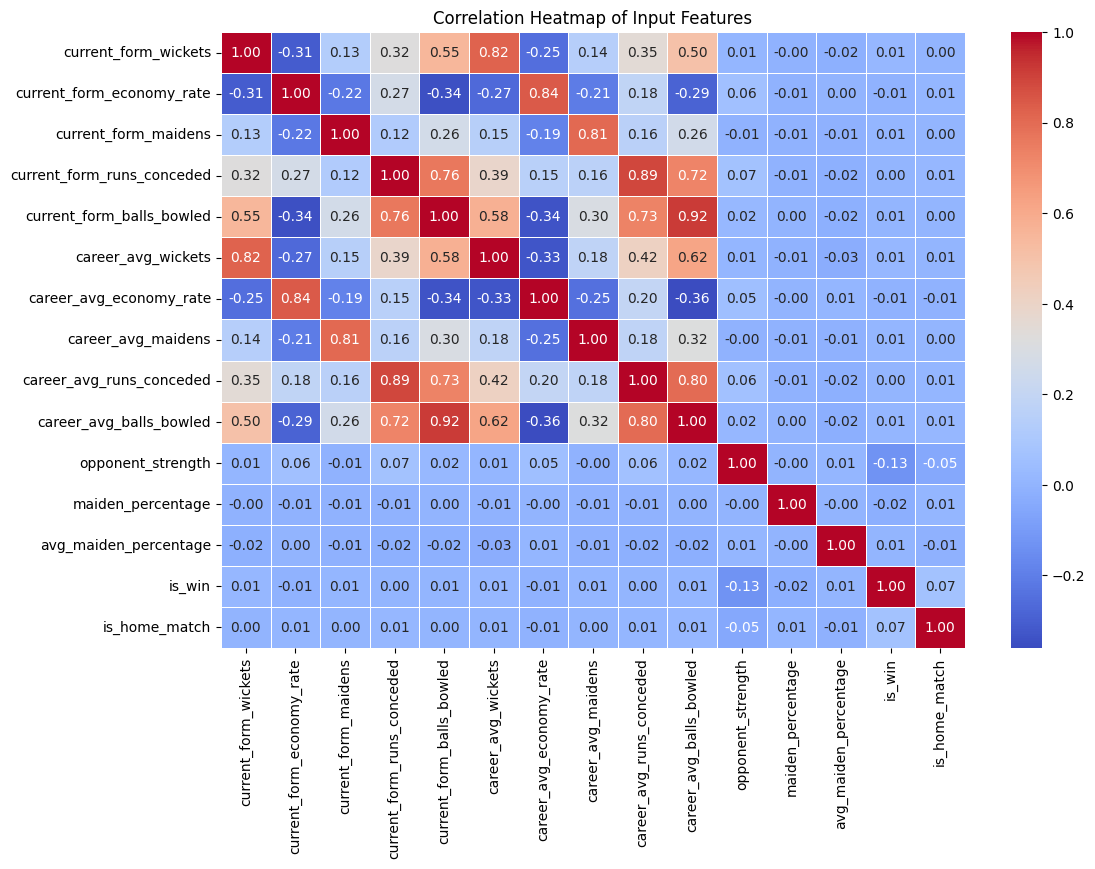

In [12]:
correlation_matrix = df_bowler[numerical_cols].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Input Features')
plt.show()

In [13]:
df = df_bowler

df['date'] = pd.to_datetime(df['date'])


train_data = df[df['date'].dt.year <= 2023]
test_data = df[df['date'].dt.year == 2024]


input_features = ['bowler',
                  'current_form_wickets', 'current_form_economy_rate', 'current_form_maidens','current_form_runs_conceded','current_form_balls_bowled',
                  'career_avg_wickets', 'career_avg_economy_rate', 'career_avg_maidens','career_avg_runs_conceded','career_avg_balls_bowled',
                  'opponent_strength', 'maiden_percentage','avg_maiden_percentage',
                  'is_win', 'is_home_match']

output_features = ['wickets', 'runs_conceded', 'balls_bowled', 'economy_rate', 'maidens','extras']

categorical_cols = ['bowler']
numerical_cols = ['current_form_wickets', 'current_form_economy_rate', 'current_form_maidens','current_form_runs_conceded','current_form_balls_bowled',
                  'career_avg_wickets', 'career_avg_economy_rate', 'career_avg_maidens','career_avg_runs_conceded','career_avg_balls_bowled',
                  'opponent_strength', 'maiden_percentage','avg_maiden_percentage',
                  'is_win', 'is_home_match']


train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_cleaned = train_data.dropna(subset=input_features + numerical_cols + output_features)

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data_cleaned = test_data.dropna(subset=input_features + numerical_cols + output_features)

X_train = train_data_cleaned[input_features]
y_train = train_data_cleaned[output_features]

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data_cleaned = test_data.dropna(subset=input_features + numerical_cols)
X_test = test_data_cleaned
y_test = test_data_cleaned[output_features]


train_players = X_train['bowler'].unique()
test_players = X_test['bowler'].unique()


missing_players = set(test_players) - set(train_players)


X_test_cleaned = X_test[~X_test['bowler'].isin(missing_players)]
y_test_cleaned = y_test.loc[X_test_cleaned.index]

X_test_cleaned_df = X_test_cleaned[input_features]

<ipython-input-13-930971beda4b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-13-930971beda4b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-13-930971beda4b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [23]:
X_test_cleaned.to_csv('/content/drive/My Drive/hackathon/streamlit_x_test_bowler_24.csv')

In [25]:
X_train = train_data_cleaned[input_features]
y_train = train_data_cleaned[output_features]

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data_cleaned = test_data.dropna(subset=input_features + numerical_cols)
X_test = test_data_cleaned[input_features]
y_test = test_data_cleaned[output_features]


train_players = X_train['bowler'].unique()
test_players = X_test['bowler'].unique()


missing_players = set(test_players) - set(train_players)


X_test_cleaned = X_test[~X_test['bowler'].isin(missing_players)]
y_test_cleaned = y_test.loc[X_test_cleaned.index]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))])

model.fit(X_train, y_train)

y_pred = model.predict(X_test_cleaned)

mse = mean_squared_error(y_test_cleaned, y_pred, multioutput='raw_values')
print(f'Mean Squared Error for each output: {mse}')

<ipython-input-25-2aa92681f0df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.replace([np.inf, -np.inf], np.nan, inplace=True)


Mean Squared Error for each output: [  1.08731892 143.41442407  31.64596216  13.03017338   0.24349987
   3.41622754]


## Storing dataframes for futher use

In [26]:
import pickle
with open('/content/drive/My Drive/hackathon/bowler_08_23.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
train_players_df = pd.DataFrame(train_players, columns=['bowler'])
train_players_df.to_csv('/content/drive/My Drive/hackathon/train_bowler_08_23.csv', index=False)

In [ ]:
X_train.to_csv('/content/drive/My Drive/hackathon/X_train_bowler_08_23.csv', index=False)
y_train.to_csv('/content/drive/My Drive/hackathon/y_train_bowler_08_23.csv', index=False)
X_test_cleaned.to_csv('/content/drive/My Drive/hackathon/X_test_bowler_24.csv', index=False)
y_test_cleaned.to_csv('/content/drive/My Drive/hackathon/y_test_bowler_24.csv', index=False)

In [ ]:
train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])

train_data_cleaned = train_data_cleaned.sort_values(by=['bowler', 'date'])

last_match_data = train_data_cleaned.groupby('bowler').tail(1)
last_match_data.to_csv('/content/drive/My Drive/hackathon/last_match_data_bowler.csv', index=False)

<ipython-input-31-ba39f96230da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])


In [22]:
import pickle
with open('/content/drive/My Drive/hackathon/dummy/bowler_08_23.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [27]:
y_pred = model.predict(X_test_cleaned)

y_pred_df = pd.DataFrame(y_pred, columns=output_features, index=X_test_cleaned.index)

results_df = X_test_cleaned.copy()
results_df['actual_wickets'] = y_test_cleaned['wickets']
results_df['predicted_wickets'] = y_pred_df['wickets']

results_df['actual_runs_conceded'] = y_test_cleaned['runs_conceded']
results_df['predicted_runs_conceded'] = y_pred_df['runs_conceded']

results_df['actual_balls_bowled'] = y_test_cleaned['balls_bowled']
results_df['predicted_balls_bowled'] = y_pred_df['balls_bowled']

results_df['actual_economy_rate'] = y_test_cleaned['economy_rate']
results_df['predicted_economy_rate'] = y_pred_df['economy_rate']

results_df['actual_maidens'] = y_test_cleaned['maidens']
results_df['predicted_maidens'] = y_pred_df['maidens']

results_df['actual_extras'] = y_test_cleaned['extras']
results_df['predicted_extras'] = y_pred_df['extras']

results_df

,bowler,current_form_wickets,current_form_economy_rate,current_form_maidens,current_form_runs_conceded,current_form_balls_bowled,career_avg_wickets,career_avg_economy_rate,career_avg_maidens,career_avg_runs_conceded,...,actual_runs_conceded,predicted_runs_conceded,actual_balls_bowled,predicted_balls_bowled,actual_economy_rate,predicted_economy_rate,actual_maidens,predicted_maidens,actual_extras,predicted_extras
12122,A Badoni,0.666667,4.000000,0.666667,4.000000,4.333333,0.666667,4.000000,0.666667,4.000000,...,6,14.61,6,14.63,6.000000,8.282653,0,0.58,0.0,0.57
12759,A Badoni,0.500000,4.500000,0.500000,4.500000,4.750000,0.500000,4.500000,0.500000,4.500000,...,19,15.55,6,13.60,19.000000,7.961718,0,0.39,0.0,0.73
12605,A Mishra,1.000000,7.942857,0.285714,21.571429,16.428571,1.130435,7.475069,0.422360,25.919255,...,20,25.00,12,19.05,10.000000,8.580998,0,0.34,0.0,0.95
12183,A Nortje,1.285714,8.543651,0.428571,35.857143,25.285714,1.375000,8.331889,0.400000,32.900000,...,50,33.61,24,22.69,12.500000,9.237355,0,0.40,2.0,1.19
12230,A Nortje,1.428571,9.250000,0.428571,38.142857,24.857143,1.365854,8.433550,0.390244,33.317073,...,45,27.81,25,23.87,10.800000,7.374774,1,0.33,3.0,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,Yash Thakur,1.428571,10.308352,0.285714,37.428571,22.142857,1.562500,9.262033,0.250000,34.937500,...,50,29.01,26,18.70,11.538462,8.060290,0,0.37,2.0,2.13
12734,Yash Thakur,1.571429,10.113846,0.285714,38.428571,23.000000,1.529412,9.395941,0.235294,35.823529,...,46,28.84,27,19.76,10.222222,8.391933,1,0.33,3.0,2.50
12769,Yash Thakur,1.428571,10.181306,0.285714,39.428571,23.428571,1.500000,9.441845,0.277778,36.388889,...,47,31.06,17,21.31,16.588235,8.429182,1,0.39,1.0,2.40
12735,Yudhvir Singh,1.000000,9.112910,1.000000,24.333333,16.666667,1.000000,9.112910,1.000000,24.333333,...,24,23.21,12,19.43,12.000000,9.047794,1,0.57,0.0,1.77


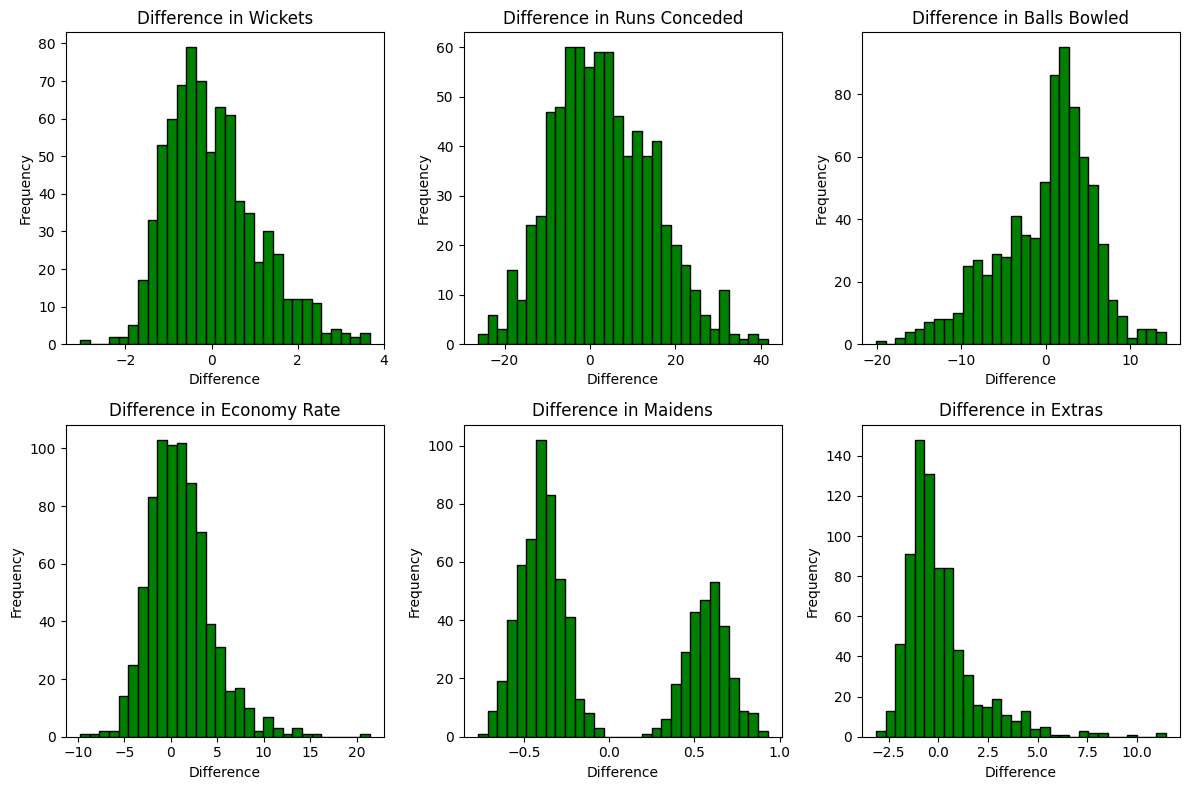

In [18]:
import matplotlib.pyplot as plt

# Calculate differences between actual and predicted values
results_df['diff_wickets'] = results_df['actual_wickets'] - results_df['predicted_wickets']
results_df['diff_runs_conceded'] = results_df['actual_runs_conceded'] - results_df['predicted_runs_conceded']
results_df['diff_balls_bowled'] = results_df['actual_balls_bowled'] - results_df['predicted_balls_bowled']
results_df['diff_economy_rate'] = results_df['actual_economy_rate'] - results_df['predicted_economy_rate']
results_df['diff_maidens'] = results_df['actual_maidens'] - results_df['predicted_maidens']
results_df['diff_extras'] = results_df['actual_extras'] - results_df['predicted_extras']

# List of differences and their labels
diff_columns = [
    ('diff_wickets', 'Wickets'),
    ('diff_runs_conceded', 'Runs Conceded'),
    ('diff_balls_bowled', 'Balls Bowled'),
    ('diff_economy_rate', 'Economy Rate'),
    ('diff_maidens', 'Maidens'),
    ('diff_extras', 'Extras')
]

# Plot histograms
plt.figure(figsize=(12, 8))

for i, (col, label) in enumerate(diff_columns):
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid for subplots
    plt.hist(results_df[col], bins=30, color='green', edgecolor='black')
    plt.title(f'Difference in {label}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout so plots don't overlap
plt.show()
